In [807]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [808]:
evds=evdsAPI('dsIC3fiGlu')


In [809]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4623,23-10-2023,28.0218
4624,24-10-2023,28.0608
4625,25-10-2023,28.1042
4626,26-10-2023,28.1313


In [810]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [811]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


In [812]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [813]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


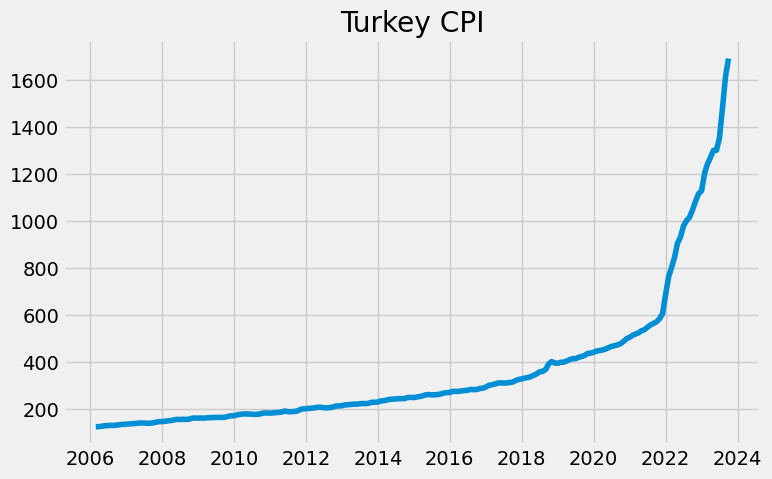

In [814]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [815]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [816]:
dates= pd.date_range('2006-02-01','2023-11-01' , freq='1M')           
df6=df6.set_index(dates)
df6


,USD/TL
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [817]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del money["Tarih"]
money['Tarih'] = pd.to_datetime(money['YEARWEEK'] + '-1', format='%Y-%W-%w')
money = money.groupby(money['Tarih'].dt.to_period('M'))['TP_PR_ARZ13'].mean()
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(df6.index)
money

,Para Arzi
2006-02-28,2.424295
2006-03-31,2.473023
2006-04-30,2.514337
2006-05-31,2.648480
2006-06-30,2.794302
...,...
2023-06-30,104.034758
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258


In [818]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(df6.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-06-30,111.098957
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411


In [819]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-09-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-04-30,10.0
2023-05-31,9.5
2023-06-30,9.6
2023-07-31,9.4


In [820]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4614,10-10-2023,90.70
4615,11-10-2023,87.58
4616,12-10-2023,88.40
4617,13-10-2023,94.33


In [821]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [822]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [823]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10


In [824]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870


In [825]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-06-30,95.646045
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870


In [826]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,23.50
211,2023-9,31.00


In [827]:
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-06-30,12.84
2023-07-31,17.50
2023-08-31,23.50


In [828]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.297500
2006-03-31,17.008000
2006-04-30,16.207500
2006-05-31,16.300000
2006-06-30,19.670000
...,...
2023-06-30,38.560000
2023-07-31,45.825000
2023-08-31,45.765000
2023-09-30,56.350000


In [829]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:169,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:169,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-09-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-04-30,165.916139,169.886079,174.404111
2023-05-31,181.176925,179.726145,180.185729
2023-06-30,180.070938,186.141640,180.131292
2023-07-31,191.355951,193.831190,185.482059


In [830]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-10-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-05-31,18.920000
2023-06-30,22.100000
2023-07-31,29.480000
2023-08-31,37.370000


In [831]:
sanayi=evds.get_data(["TP.SANAYREV4.Y1"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
sanayi=sanayi.set_index(pd.date_range(start="2006-02-01",end="2023-09-01",freq="1M"))
del sanayi["Tarih"]
sanayi.columns=["Sanayi"]
sanayi

,Sanayi
2006-02-28,55.819129
2006-03-31,65.933232
2006-04-30,62.501869
2006-05-31,66.499838
2006-06-30,67.519860
...,...
2023-04-30,129.873251
2023-05-31,149.379361
2023-06-30,137.891848
2023-07-31,145.483816


In [832]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-11-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
2006-06-30,15.584000
...,...
2023-06-30,39.592000
2023-07-31,33.125000
2023-08-31,29.412500
2023-09-30,41.656000


In [833]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-11-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-06-30,7.55
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30


In [834]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate="30-10-2023",frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-10-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-05-31,2.348115e+09
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09


In [835]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate="30-10-2023",frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-10-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-05-31,94.52
2023-06-30,87.07
2023-07-31,81.77
2023-08-31,84.81


In [836]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate="30-10-2023",frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-10-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-05-31,58.00
2023-06-30,51.60
2023-07-31,48.71
2023-08-31,52.42


In [837]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.head(211)
data=data.dropna(axis=0)
data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,REDK,REDKT,M3,TÜFE
2011-04-30,-0.810542,2.440539,-1.218711,-0.176965,-3.796845,0.684613,2.978727,1.593625,2.284537,1.642254,0.866270
2011-05-31,-0.399628,0.458932,-1.660706,1.110822,4.626047,0.570506,3.568114,-3.090570,-1.121135,0.477281,2.420827
2011-06-30,0.415548,1.955789,2.055258,2.490629,4.308985,0.194110,3.122424,-1.878794,-3.463549,2.450559,-1.430743
2011-07-31,2.804715,1.982717,2.237631,1.258223,-1.324582,0.019793,2.898935,-3.289474,-3.817214,2.189939,-0.409400
2011-08-31,3.747733,0.951638,1.664460,-0.296514,-3.655736,0.318355,3.279260,-4.213626,-5.533295,0.444077,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,3.880167,-1.492537,0.772387,-14.132513,10.507274,5.406548,-2.000628,-0.873069,4.189763,2.385509
2023-05-31,1.507585,4.857908,-7.526882,3.315070,15.019343,2.663712,3.535416,1.026080,-1.761518,4.796282,0.043076
2023-06-30,7.066073,0.788974,16.807611,-0.030212,-7.690161,2.406884,5.711697,-7.881930,-11.034483,-1.142443,3.920498
2023-07-31,11.475241,9.567224,33.393665,2.970482,5.505741,9.689321,5.675617,-6.087056,-5.600775,15.439600,9.488824


In [838]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','Şok','M3','İşsizlik',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,TÜFE
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,-13.258747,0.82,1.817559,-0.584687,3.267877,9.0220,-3.691204,-5.094658,1,3.413428,9.2,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-4.776023,0.73,3.306415,0.808574,1.451593,10.6275,2.179150,0.919060,0,2.079333,9.5,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,12.632839,0.80,0.500514,0.193691,0.341852,11.3125,0.471546,0.641623,1,0.229599,9.5,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-1.068156,0.73,1.106676,0.478162,0.129671,11.0200,4.682667,5.892031,1,0.730196,9.7,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,1.476989,0.80,-0.699811,0.091080,0.468727,10.4940,1.283880,2.058652,0,-0.093468,9.7,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,-1.492537,0.772387,29.2275,0.00,-14.132513,7.51,3.880167,10.507274,5.406548,28.3425,-2.000628,-0.873069,0,4.189763,10.0,2.385509
2023-05-31,1.507585,-7.526882,3.315070,32.0225,0.00,15.019343,7.37,4.857908,2.663712,3.535416,31.4625,1.026080,-1.761518,0,4.796282,9.5,0.043076
2023-06-30,7.066073,16.807611,-0.030212,38.5600,0.00,-7.690161,7.55,0.788974,2.406884,5.711697,39.5920,-7.881930,-11.034483,0,-1.142443,9.6,3.920498
2023-07-31,11.475241,33.393665,2.970482,45.8250,34.00,5.505741,7.70,9.567224,9.689321,5.675617,33.1250,-6.087056,-5.600775,1,15.439600,9.4,9.488824


In [839]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Borç', 'REDK', 'REDKT']
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model=LinearRegression()
model.fit(X_train,y_train)
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [840]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Zam', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Mevduat Faizi']
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model=RandomForestRegressor()
model.fit(X_train,y_train)

        


tahminler["Aylık Enflasyon"]=y_test
tahminler["Random Forest"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Random Forest"])))


In [841]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Borç', 'REDK', 'REDKT', 'Şok', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [842]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Borç', 'REDK', 'REDKT', 'Şok', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [843]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Borç', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [844]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Borç', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [845]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Sanayi', 'ParaArzi', 'REDK']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 50, seed = 123)
model.fit(X_train,y_train)

tahminler["XGBoost"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["XGBoost"])))

In [846]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Borç', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [847]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [848]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Kernel Regression,0.044483
XGBoost,0.070066
Linear Regression,0.091870
Lars Regression,0.091870
Gaussian Regression,0.111651
Bayesian Regression,0.131679
SGD Regressor,0.144795
Lasso Regression,0.153483
Random Forest,0.301712


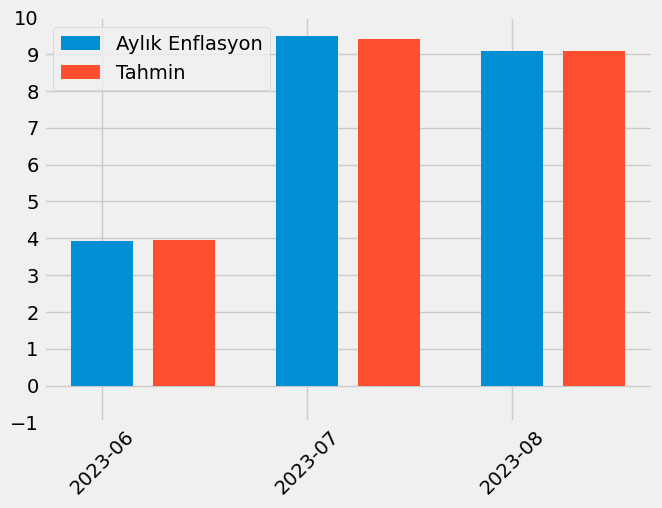

In [849]:
X_axis = np.arange(len(tahminler))
plt.figure(figsize=(7,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.4,tahminler["Kernel Regression"],width=0.3,label="Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.yticks(np.arange(-1,11,1))
plt.legend()

In [850]:
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(df6["USD/TL"], order=(0,1,1),seasonal_order=(1,1,0,12))
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=15)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.809140
2023-11-30,28.868363
2023-12-31,30.871160
2024-01-31,30.906135
2024-02-29,30.995874
2024-03-31,31.670103


In [851]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import month_plot
import warnings


model = SARIMAX(df14["Brent"], order=(1, 1, 0), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
brenttahmin=pd.DataFrame(forecast_values)
brenttahmin.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[209:213,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
brenttahmin=pd.concat([row,brenttahmin],axis=0)
brenttahmin

,Brent
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.455455
2023-11-30,88.343082
2023-12-31,85.431383
2024-01-31,90.291657
2024-02-29,95.526542
2024-03-31,99.282546
2024-04-30,98.923810


In [852]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1,1,1),seasonal_order=(0,1,1,12))
model_fit = model.fit()
perakendetahmin = model_fit.forecast(steps=15)
perakendetahmin=pd.DataFrame(perakendetahmin)
perakendetahmin.columns=["Perakende"]
row=pd.DataFrame({"Perakende":perakende1.iloc[163,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
perakendetahmin=pd.concat([row,perakendetahmin],axis=0)
perakendetahmin

,Perakende
2023-08-31,184.748497
2023-09-30,177.058336
2023-10-31,178.125306
2023-11-30,179.371911
2023-12-31,179.533206
2024-01-31,180.650546
2024-02-29,180.458038
2024-03-31,182.407175
2024-04-30,180.242428
2024-05-31,181.499598


In [853]:
model = SARIMAX(money["Para Arzi"], order=(2,1,2),seasonal_order=(0,1,1,12))
model_fit = model.fit()


# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:213,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258
2023-10-31,125.040807
2023-11-30,129.186754
2023-12-31,134.195424
2024-01-31,137.856381
2024-02-29,141.854840
2024-03-31,146.657833
2024-04-30,151.630687


In [854]:
model = SARIMAX(kfaiz["Kredi Faizi"], order=(1,1,0),seasonal_order=(1,1,2,12))
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.713333
2023-11-30,60.147187
2023-12-31,60.919418
2024-01-31,61.060058
2024-02-29,59.402961
2024-03-31,58.474743
2024-04-30,58.427005
2024-05-31,59.053824


In [855]:
model = ARIMA(mfaiz, order=(3, 1, 0))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-08-31,29.412500
2023-09-30,41.656000
2023-10-31,44.616667
2023-11-30,36.577175
2023-12-31,39.331064
2024-01-31,46.705823
2024-02-29,43.043976
2024-03-31,39.183307
2024-04-30,44.280656
2024-05-31,46.151471


In [856]:
usdtahmin["brent"]=brenttahmin
usdtahmin=usdtahmin.dropna(axis=0)
degisim=pd.DataFrame((((usdtahmin["USDTL"]*usdtahmin["brent"]).pct_change(periods=1)+1).values)[1:],index=pd.date_range(start="2023-08-30",end="2025-02-27",freq="1M"))
degisim.columns=["Değişim"]
degisim=degisim.iloc[1:17]
degisim

,Değişim
2023-09-30,1.087536
2023-10-31,0.994455
2023-11-30,1.013847
2023-12-31,1.034131
2024-01-31,1.058088
2024-02-29,1.061049
2024-03-31,1.061926
2024-04-30,1.002408
2024-05-31,1.020183
2024-06-30,1.101717


In [857]:
motorintahmin=pd.DataFrame()
motorintahmin["Değişim"]=degisim
motorintahmin["Motorin"]=39.18
for i in range(1,16):
    motorintahmin.iloc[i,1]=motorintahmin.iloc[i,0]*motorintahmin.iloc[i-1,1]

del motorintahmin["Değişim"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[247,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.962736
2023-11-30,39.502249
2023-12-31,40.850512
2024-01-31,43.223451
2024-02-29,45.862219
2024-03-31,48.702303
2024-04-30,48.819603
2024-05-31,49.804945


In [858]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2025-01-30",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [859]:
model = ARIMA(df3["Kredi"], order=(3, 1, 3))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":[98.46,99.23,102.58,103.18]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-07-31,98.460000
2023-08-31,99.230000
2023-09-30,102.580000
2023-10-31,103.180000
2023-11-30,103.503120
2023-12-31,105.765667
2024-01-31,107.369391
2024-02-29,106.925230
2024-03-31,108.530284
2024-04-30,110.344978


In [860]:
model = ARIMA(borc["Borç"], order=(1, 1, 2), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":[2643068440,2758965144,2859751220]},index=pd.date_range(start="2023-07-30",end="2023-10-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.934016e+09
2023-11-30,3.005940e+09
2023-12-31,3.069800e+09
2024-01-31,3.128332e+09
2024-02-29,3.183702e+09
2024-03-31,3.236235e+09
2024-04-30,3.280363e+09


In [861]:
model = SARIMAX(redk["REDK"], order=(2, 1, 0), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redktahmin=pd.DataFrame(forecast_values)
redktahmin.columns=["REDK"]
new_row=pd.DataFrame({"REDK":[84.81,88.29]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
redktahmin=pd.concat([new_row,redktahmin],axis=0)
redktahmin

,REDK
2023-08-31,84.810000
2023-09-30,88.290000
2023-10-31,87.997770
2023-11-30,87.214358
2023-12-31,85.531698
2024-01-31,86.984450
2024-02-29,88.983093
2024-03-31,88.439166
2024-04-30,88.321581
2024-05-31,88.268137


In [862]:
model = SARIMAX(redkt["REDKT"], order=(2, 1, 0), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redkttahmin=pd.DataFrame(forecast_values)
redkttahmin.columns=["REDKT"]
new_row=pd.DataFrame({"REDKT":[52.42,55.52]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
redkttahmin=pd.concat([new_row,redkttahmin],axis=0)
redkttahmin

,REDKT
2023-08-31,52.420000
2023-09-30,55.520000
2023-10-31,55.807175
2023-11-30,54.435473
2023-12-31,52.551396
2024-01-31,53.485479
2024-02-29,54.657562
2024-03-31,53.617185
2024-04-30,53.457812
2024-05-31,52.151740


In [863]:
model = ARIMA(m3["M3 Para Arzi"], order=(1, 1, 1))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 15# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
m3tahmin=pd.DataFrame(forecast_values)
m3tahmin.columns=["M3 Para Arzi"]
new_row=pd.DataFrame({"M3 Para Arzi":[117.729649878,123.43,126.66,127.9]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
m3tahmin=pd.concat([new_row,m3tahmin],axis=0)
m3tahmin

,M3 Para Arzi
2023-07-31,117.729650
2023-08-31,123.430000
2023-09-30,126.660000
2023-10-31,127.900000
2023-11-30,134.438904
2023-12-31,138.847986
2024-01-31,143.245383
2024-02-29,147.631128
2024-03-31,152.005250
2024-04-30,156.367780


In [864]:
model = SARIMAX(issizlik["İşsizlik"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 17# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
issizliktahmin=pd.DataFrame(forecast_values)
issizliktahmin.columns=["İşsizlik"]
new_row=pd.DataFrame({"İşsizlik":[9.2]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
issizliktahmin=pd.concat([new_row,issizliktahmin],axis=0)
issizliktahmin

,İşsizlik
2023-08-31,9.200000
2023-09-30,9.128270
2023-10-31,9.096536
2023-11-30,9.149132
2023-12-31,9.186304
2024-01-31,9.256840
2024-02-29,9.307002
2024-03-31,9.341871
2024-04-30,9.415606
2024-05-31,9.422929


In [865]:
model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 17# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
enfbelirsizliktahmin=pd.DataFrame(forecast_values)
enfbelirsizliktahmin.columns=["Enflasyon Belirsizliği"]
new_row=pd.DataFrame({"Enflasyon Belirsizliği":[6.81,7.3,5.57]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([new_row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin

,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,5.805533
2023-12-31,6.972540
2024-01-31,7.940352
2024-02-29,6.897245
2024-03-31,7.419293
2024-04-30,7.356433
2024-05-31,7.693614


In [866]:
model = SARIMAX(sanayi["Sanayi"], order=(0, 1, 1), seasonal_order=(2, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 17# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
sanayitahmin=pd.DataFrame(forecast_values)
sanayitahmin.columns=["Sanayi"]
new_row=pd.DataFrame({"Sanayi":[149.23]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
sanayitahmin=pd.concat([new_row,sanayitahmin],axis=0)
sanayitahmin

,Sanayi
2023-08-31,149.230000
2023-09-30,150.367375
2023-10-31,154.168262
2023-11-30,153.574592
2023-12-31,162.950974
2024-01-31,141.743172
2024-02-29,133.967854
2024-03-31,154.022459
2024-04-30,138.777976
2024-05-31,151.289525


In [867]:

model = SARIMAX(df6["USD/TL"], order=(0,1,1),seasonal_order=(1,1,0,12))
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=15)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.809140
2023-11-30,28.868363
2023-12-31,30.871160
2024-01-31,30.906135
2024-02-29,30.995874
2024-03-31,31.670103


In [868]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USDTL"].rolling(3).mean(),paraarzitahmin["Para Arzi"].shift(1),motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin,kreditahmin.rolling(2).mean(),redktahmin,redkttahmin,m3tahmin.shift(1),borctahmin.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin



tahmindf["Şok"]=0

tahmindf=tahmindf[['USDTL', 'Motorin', 'Perakende', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDK','REDKT','Şok','M3 Para Arzi','İşsizlik']]

tahmindf.columns=data.columns[:16]
tahmindf=tahmindf.dropna(axis=0)
tahmindf

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik
2023-09-30,5.071342,4.843457,-4.162503,56.350000,0.0,0.762162,7.300000,5.195375,4.384930,2.084071,41.656000,4.103290,5.913773,0,4.841898,9.128270
2023-10-31,1.663957,-0.554529,0.602610,59.713333,0.0,2.527734,5.570000,2.782256,3.653039,1.957287,44.616667,-0.330989,0.517247,0,2.616868,9.096536
2023-11-30,2.285193,1.384690,0.699847,60.147187,0.0,-0.385079,5.805533,2.136445,2.596909,0.448639,36.577175,-0.890264,-2.457931,0,0.978999,9.149132
2023-12-31,4.639481,3.413130,0.089922,60.919418,0.0,6.105425,6.972540,3.315676,2.451355,1.251029,39.331064,-1.929338,-3.461120,0,5.112513,9.186304
2024-01-31,3.537455,5.808836,0.622358,61.060058,35.0,-13.014836,7.940352,3.877077,2.124462,1.847514,46.705823,1.698496,1.777465,0,3.279618,9.256840
2024-02-29,2.347064,6.104946,-0.106563,59.402961,0.0,-5.485497,6.897245,2.728079,1.906729,0.544051,43.043976,2.297701,2.191405,0,3.167059,9.307002
2024-03-31,0.861179,6.192644,1.080105,58.474743,0.0,14.969714,7.419293,2.900452,1.769946,0.541728,39.183307,-0.611270,-1.903447,0,3.061700,9.341871
2024-04-30,1.020998,0.240850,-1.186766,58.427005,0.0,-9.897572,7.356433,3.385851,1.650048,1.587218,44.280656,-0.132956,-0.297242,0,2.962872,9.415606
2024-05-31,1.711068,2.018333,0.697488,59.053824,0.0,9.015515,7.693614,3.390787,1.363583,0.578153,46.151471,-0.060510,-2.443183,0,2.869987,9.422929
2024-06-30,3.100624,10.171691,2.193445,59.355011,0.0,-4.013370,8.169423,2.697200,1.245428,0.174717,41.634736,-0.374041,-1.066576,0,2.782523,9.100212


In [869]:
features=tahmindf.columns


X = data[features]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1614.31
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-09-30", end="2025-01-30", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-09-30,1701.911548
2023-10-31,1756.277676
2023-11-30,1799.271023
2023-12-31,1864.402842
2024-01-31,1968.100377
2024-02-29,2042.700494
2024-03-31,2104.418008
2024-04-30,2166.088906
2024-05-31,2225.371326
2024-06-30,2307.522521


In [870]:
features=tahmindf.columns


X = data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1614.31
lineartahmin = model.predict(tahmindf[features])
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-09-30", end="2025-01-30", freq="1M"))
tüfetahmin2


,Linear Regression
2023-09-30,1713.230781
2023-10-31,1777.273354
2023-11-30,1821.777964
2023-12-31,1891.945157
2024-01-31,2004.261569
2024-02-29,2085.532474
2024-03-31,2147.831069
2024-04-30,2215.166712
2024-05-31,2269.264410
2024-06-30,2353.013290


In [871]:
features=tahmindf.columns

X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfetahmin5 = []
result = 1614.31
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-09-30", end="2025-01-30", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-09-30,1704.050220
2023-10-31,1759.757272
2023-11-30,1804.806945
2023-12-31,1874.774423
2024-01-31,1984.977300
2024-02-29,2063.646064
2024-03-31,2129.185707
2024-04-30,2193.638379
2024-05-31,2255.443350
2024-06-30,2343.126825


In [872]:
features=['USDTL', 'Kredi Faizi', 'Zam', 'Sanayi', 'Kredi', 'REDK']

X = data[features]
reg = linear_model.Lars()
reg.fit(X,y)



tüfetahmin6 = []
result = 1614.31
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-09-30", end="2025-01-30", freq="1M"))
tüfetahmin6


,Lars Regression
2023-09-30,1707.645469
2023-10-31,1782.396722
2023-11-30,1852.250582
2023-12-31,1944.292220
2024-01-31,2085.946103
2024-02-29,2174.834425
2024-03-31,2254.898984
2024-04-30,2339.690124
2024-05-31,2432.712059
2024-06-30,2530.405116


In [873]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
krr = KernelRidge()
krr.fit(X, y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
krrtahmin=krr.predict(tahmindf[features])
krrtahmin=1+(krrtahmin/100)
result = 1614.31
tüfetahmin7 = []
for i in range(krrtahmin.shape[0]):
    result *= krrtahmin[i, 0]
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7=pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns=["Kernel Regression"]
tüfetahmin7=tüfetahmin7.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin7

,Kernel Regression
2023-09-30,1697.188634
2023-10-31,1745.645636
2023-11-30,1788.290500
2023-12-31,1845.753985
2024-01-31,1921.783609
2024-02-29,1990.420200
2024-03-31,2056.438663
2024-04-30,2119.275712
2024-05-31,2170.037424
2024-06-30,2252.640773


In [874]:



features=tahmindf.columns
X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y) 


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-09-30,1709.788206
2023-10-31,1769.537038
2023-11-30,1810.331213
2023-12-31,1876.727945
2024-01-31,1984.662461
2024-02-29,2062.241872
2024-03-31,2121.067230
2024-04-30,2183.935477
2024-05-31,2236.128842
2024-06-30,2317.043624


In [875]:
features=tahmindf.columns
X = data[features]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-09-30,1702.858153
2023-10-31,1756.847189
2023-11-30,1800.307598
2023-12-31,1868.874187
2024-01-31,1976.529951
2024-02-29,2053.394797
2024-03-31,2117.923620
2024-04-30,2180.303922
2024-05-31,2240.810947
2024-06-30,2327.777915


In [876]:



features=tahmindf.columns
X = data[features]
model = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 50, seed = 123)
model.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
xgbtahmin=model.predict(tahmindf[features])
xgbtahmin=1+(xgbtahmin/100)
for elem in xgbtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin10.columns=["XGBoost"]

tüfetahmin10

,XGBoost
2023-09-30,1708.235145
2023-10-31,1750.263888
2023-11-30,1794.420839
2023-12-31,1870.168659
2024-01-31,1932.440450
2024-02-29,1994.048765
2024-03-31,2056.206852
2024-04-30,2108.037501
2024-05-31,2162.193150
2024-06-30,2234.989701


In [877]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["XGBoost"]=tüfetahmin10["XGBoost"]
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,XGBoost
2023-09-30,1701.911548,1713.230781,1704.050220,1707.645469,1697.188634,1709.788206,1702.858153,1708.235145
2023-10-31,1756.277676,1777.273354,1759.757272,1782.396722,1745.645636,1769.537038,1756.847189,1750.263888
2023-11-30,1799.271023,1821.777964,1804.806945,1852.250582,1788.290500,1810.331213,1800.307598,1794.420839
2023-12-31,1864.402842,1891.945157,1874.774423,1944.292220,1845.753985,1876.727945,1868.874187,1870.168659
2024-01-31,1968.100377,2004.261569,1984.977300,2085.946103,1921.783609,1984.662461,1976.529951,1932.440450
2024-02-29,2042.700494,2085.532474,2063.646064,2174.834425,1990.420200,2062.241872,2053.394797,1994.048765
2024-03-31,2104.418008,2147.831069,2129.185707,2254.898984,2056.438663,2121.067230,2117.923620,2056.206852
2024-04-30,2166.088906,2215.166712,2193.638379,2339.690124,2119.275712,2183.935477,2180.303922,2108.037501
2024-05-31,2225.371326,2269.264410,2255.443350,2432.712059,2170.037424,2236.128842,2240.810947,2162.193150
2024-06-30,2307.522521,2353.013290,2343.126825,2530.405116,2252.640773,2317.043624,2327.777915,2234.989701


In [878]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[3]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[4]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[5]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[6]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[7]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








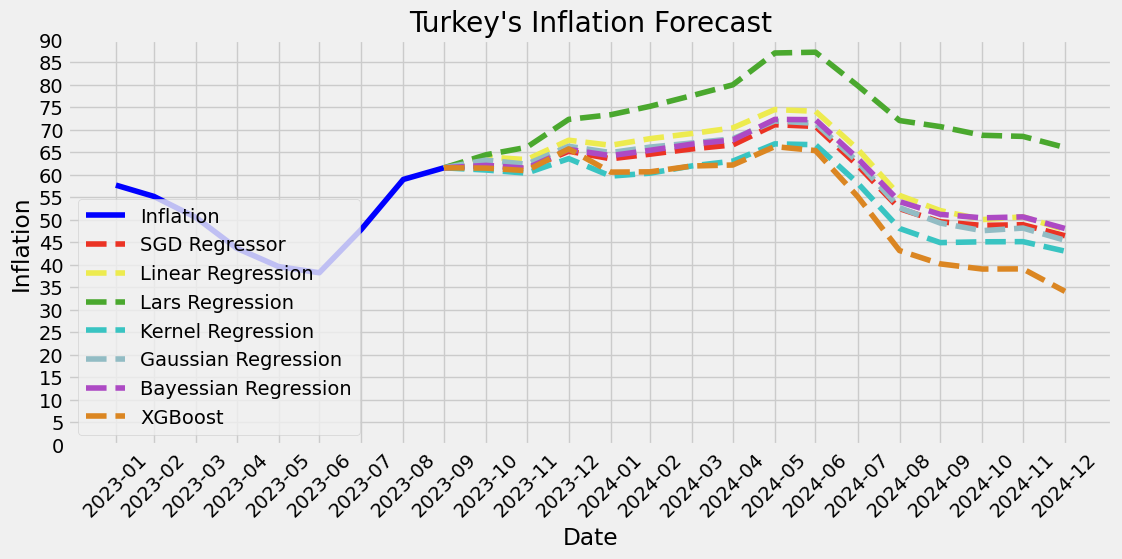

In [879]:








# Grafik çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.iloc[191:200,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[199:,0],'--',label=dfas.columns[0], color='#EB3324')
plt.plot(dfas.iloc[199:,1],'--',label=dfas.columns[1], color='#EDEB4F')
plt.plot(dfas.iloc[199:,2],'--',label=dfas.columns[2], color='#4AA82E')
plt.plot(dfas.iloc[199:,3],'--',label=dfas.columns[3], color='#39C4C2')
plt.plot(dfas.iloc[199:,4],'--',label=dfas.columns[4],color='#92BCC4')
plt.plot(dfas.iloc[199:,5],'--',label=dfas.columns[5],color='#AD4AC4')
plt.plot(dfas.iloc[199:,6],'--',label=dfas.columns[6],color='#DB8622')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:].index, dfas.iloc[191:].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [0]
while y_ticks[-1] < 90:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation Forecast")
plt.legend(loc=3)
plt.grid(True)
plt.show()


In [880]:
eylül_tahmin=((tüfetahmin.iloc[0,:]/1614.31)-1)*100
np.abs(eylül_tahmin-4.75).sort_values()

Kernel Regression       0.383997
SGD Regressor           0.676563
Bayessian Regression    0.735201
Lasso Regression        0.809045
Lars Regression         1.031756
XGBoost                 1.068284
Gaussian Regression     1.164490
Linear Regression       1.377744
Name: 2023-09-30 00:00:00, dtype: float64

In [881]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
row=pd.DataFrame({eylül_tahmin.index[0]:eylül_tahmin[0],eylül_tahmin.index[1]:eylül_tahmin[1],eylül_tahmin.index[2]:eylül_tahmin[2],eylül_tahmin.index[3]:eylül_tahmin[3],eylül_tahmin.index[4]:eylül_tahmin[4],eylül_tahmin.index[5]:eylül_tahmin[5],eylül_tahmin.index[6]:eylül_tahmin[6],eylül_tahmin.index[7]:eylül_tahmin[7]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,XGBoost,Ortalama,Medyan
2023-09-30,5.426563,6.127744,5.559045,5.781756,5.133997,5.914490,5.485201,5.818284,5.655885,5.655885
2023-10-31,3.194416,3.738117,3.269097,4.377446,2.855134,3.494517,3.170495,2.460361,3.319948,3.269097
2023-11-30,2.447981,2.504095,2.559994,3.919097,2.442928,2.305359,2.473773,2.522874,2.647013,2.504095
2023-12-31,3.619900,3.851578,3.876729,4.969179,3.213319,3.667657,3.808604,4.221296,3.903533,3.851578
2024-01-31,5.561970,5.936558,5.878194,7.285627,4.119163,5.751207,5.760461,3.329742,5.452865,5.751207
2024-02-29,3.790463,4.054905,3.963207,4.261295,3.571505,3.908947,3.888878,3.188109,3.828414,3.888878
2024-03-31,3.021369,2.987179,3.175915,3.681409,3.316810,2.852496,3.142543,3.117180,3.161863,3.142543
2024-04-30,2.930544,3.135053,3.027104,3.760308,3.055625,2.963991,2.945352,2.520692,3.042334,3.027104
2024-05-31,2.736841,2.442150,2.817464,3.975823,2.395239,2.389877,2.775165,2.569008,2.762696,2.736841
2024-06-30,3.691572,3.690574,3.887638,4.015808,3.806540,3.618521,3.881049,3.366792,3.744812,3.744812


In [882]:
yıllıktahmin=pd.DataFrame(dfas)
yıllıktahmin["Ortalama"]=yıllıktahmin.mean(axis=1)
yıllıktahmin["Medyan"]=yıllıktahmin.median(axis=1)
yıllıktahmin.tail(16)


,SGD Regressor,Linear Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,XGBoost,Ortalama,Medyan
2023-09-30,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865
2023-10-31,62.018236,63.955106,64.427742,61.037420,63.241424,62.070774,61.463458,62.602023,62.336398
2023-11-30,61.331978,63.350068,66.082401,60.347408,62.323692,61.424923,60.897086,62.251079,61.838001
2023-12-31,65.218028,67.658749,72.297596,63.565420,66.310244,65.614266,65.728979,66.627612,66.019611
2024-01-31,63.534116,66.538835,73.326196,59.685546,64.910299,64.234549,60.571048,64.685798,64.460174
2024-02-29,64.557410,68.007901,75.201955,60.345774,66.131639,65.418929,60.638087,65.757385,65.588157
2024-03-31,65.734830,69.153855,77.586059,61.956185,67.046051,66.798474,61.937929,67.173340,66.922262
2024-04-30,66.617097,70.392197,79.970626,63.016193,67.989868,67.710526,62.151742,68.264035,67.850197
2024-05-31,71.103439,74.478272,87.045368,66.848948,71.930558,72.290554,66.245821,72.848995,72.110556
2024-06-30,70.726516,74.092239,87.216916,66.665984,71.430953,72.225151,65.360035,72.531114,71.828052


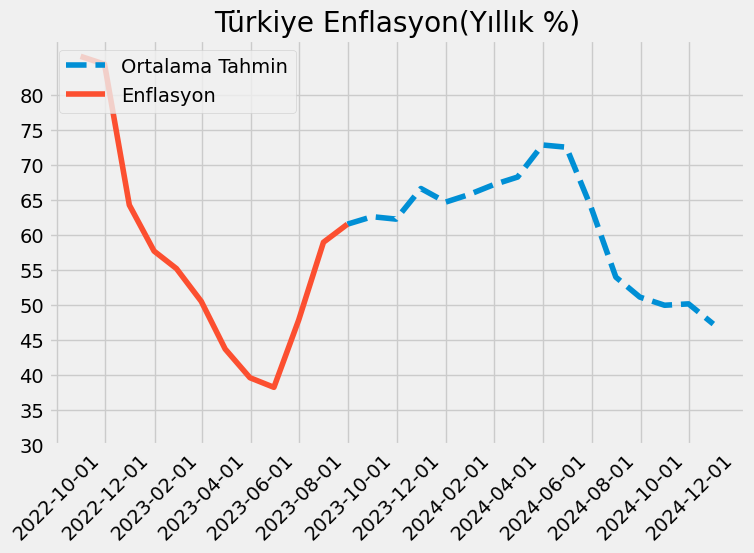

In [883]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,5))
plt.plot(yıllıktahmin["Ortalama"].tail(16),'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[-27:-15],label="Enflasyon")
plt.xticks(yıllıktahmin.tail(27).index.strftime("%Y-%m")[::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()